In [ ]:
import numpy as np
from src.solution_methods.linear_programming.cplex_dual_cmdp_solver import solve_CMDP_for_policy
from src.concrete_decision_processes.maze_cmdp import RoseMazeCMDP

cmdp = RoseMazeCMDP()
policy, solution_details = solve_CMDP_for_policy(cmdp)
policy.validate()

In [2]:
assert np.allclose(policy.policy_matrix.sum(axis=1), 1.0), policy.policy_matrix.sum(axis=1)

Since we only consider stationary policies, To find the occupancy measures for the policy $\pi$, we can first find the discounted occupancy measures for each state.
Let $\mathbf{q} \in \mathbb{R}^{|S|}$ be a vector representing the discounted number of visits to each state:
$$
\mathbf{q}[i] = \sum_{t=0}^{\infty} \gamma^t \mathbb{P}[S_t = s_i]
$$

We can decompose $\mathbf{q}$ into a geometric sum of an infinite series of vectors:
$$
\mathbf{q} = \mathbf{d}_0 + \gamma \mathbf{d}_1 + \gamma^2 \mathbf{d}_2 + \ldots
$$

Where each $\mathbf{d}_t[i] = \mathbb{P}[S_t = s_i]$.
Each of these vectors could be calculated as the distribution of a Markov chain with initial distribution $\mathbf{d}_0 = I$ and $P[i,j] = \mathbb{P}[S_{t+1}=s_j \mid S_t = s_i] = \sum_{a \in A} \pi(a \mid s_i) T(s_j \mid s_i, a)$. In particular, $\mathbf{d}_{t+1} = \mathbf{d}_{t} P = \mathbf{d}_{0} P^{t+1}$.

We can write  decompose this as:
$$
\mathbf{q} = \mathbf{d}_0 + \gamma \mathbf{d}_1 + \gamma^2 \mathbf{d}_2 + \ldots
\\ = \mathbf{d}_0 + \gamma P (\mathbf{d}_0 + \gamma P (\mathbf{d}_0 + \gamma P (\ldots)))
$$
We should then be able to calculate this as a series:
$$
\mathbf{q}_0 = \mathbf{d}_0
$$
$$
\mathbf{q}_{t+1} = \mathbf{d}_0 + \gamma \mathbf{q}_{t} P
$$
We can see that $lim_{t \to \infty} \ (\mathbf{q}_t) = \mathbf{q}$

In [3]:
d_0 = cmdp.start_state_probabilities
assert d_0.sum() == 1.0

In [4]:
policy.policy_matrix[2:4, :]

array([[0.   , 0.686, 0.   , 0.314],
       [0.   , 0.   , 0.   , 1.   ]])

In [5]:
policy.policy_matrix.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [6]:
# P[i,j] = Σ T[i, a, j] π[i, a]
P = np.einsum('iaj,ia->ij', cmdp.transition_matrix, policy.policy_matrix)
assert P.shape == (cmdp.n_states, cmdp.n_states)
assert np.allclose(P.sum(axis=1), 1.0)

In [7]:
d_0 = d_0
ds = [d_0]
for t in range(0, 20):
    d_t = ds[-1]
    d_tp1 = d_t @ P
    ds.append(d_tp1)
d_mat = np.stack(ds).T
d_mat.shape

(9, 21)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


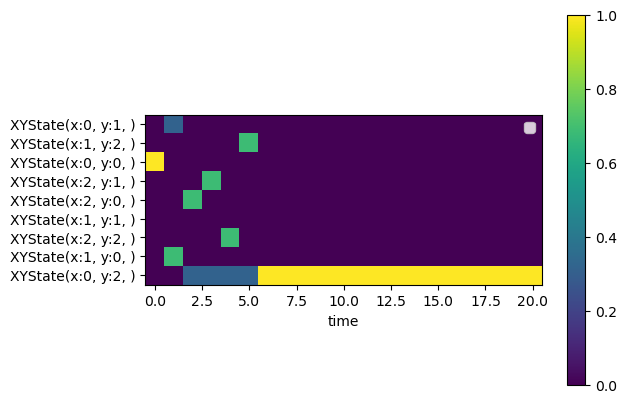

In [8]:
import matplotlib.pyplot as plt
plt.imshow(d_mat)
plt.yticks(list(range(cmdp.n_states)), cmdp.state_list)
plt.xlabel("time")
plt.colorbar()
plt.legend()

In [9]:
q_0 = d_0
qs = [q_0]
for t in range(0, 1000000):
    q_t = qs[-1]
    q_tp1 = d_0 + (cmdp.gamma * (q_t @ P))
    qs.append(q_tp1)
print(f"1/(1-γ)={1/(1-cmdp.gamma)}")
print(f"q_{t+1}.sum() = {q_tp1.sum()}")
print(q_tp1.sum() / (1/(1-cmdp.gamma)))
q_mat = np.stack(qs).T
q_mat.shape

1/(1-γ)=10.000000000000002
q_1000000.sum() = 9.999999999999995
0.9999999999999993


(9, 1000001)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


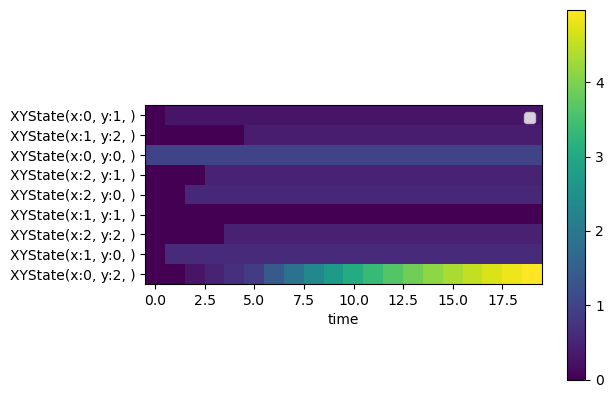

In [10]:
import matplotlib.pyplot as plt
plt.imshow(q_mat[:, :20])
plt.yticks(list(range(cmdp.n_states)), cmdp.state_list)
plt.xlabel("time")
plt.colorbar()
plt.legend()

$$
\mathbf{q} = \mathbf{d}_0 + \gamma \mathbf{q} P
$$

In [11]:
(d_0 - (q_tp1 @ (np.identity(cmdp.n_states) - (cmdp.gamma *P)))).sum()

6.661338147750939e-16

If $(I - \gamma P)$ is invertible:
$$
\mathbf{q} = (I - \gamma P)^{-1} \mathbf{d}_0
$$

In [12]:
inverse = np.linalg.inv((np.identity(cmdp.n_states) - (cmdp.gamma *P)))
q_guess1 = inverse @ d_0
q_guess2 = d_0 @ inverse

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


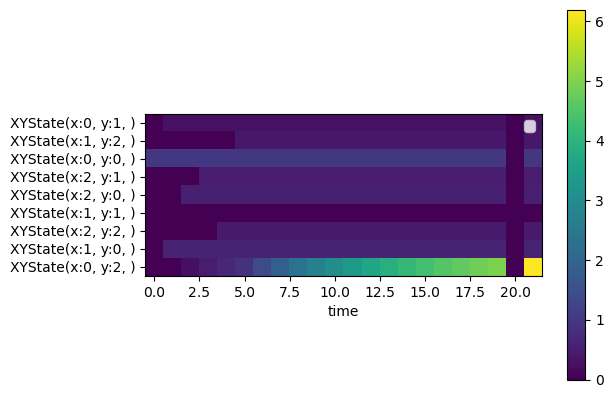

In [13]:
import matplotlib.pyplot as plt
stacked = np.hstack([q_mat[:, :20], np.zeros((cmdp.n_states, 1)), q_guess2.reshape(-1, 1)])
plt.imshow(stacked)
plt.yticks(list(range(cmdp.n_states)), cmdp.state_list)
plt.xlabel("time")
plt.colorbar()
plt.legend()

In [51]:
def get_unit_eigenvector_corresponding_to_eigenavalue_1(A: np.ndarray) -> np.ndarray:
    eigen_values, eigen_vectors = np.linalg.eig(A)
    #
    # for eigen_vector in eigen_vectors:
    #     print((A @ eigen_vector) - eigen_vector)

    close_to_one_indeces = np.isclose(eigen_values, 1.0)
    eigen_vectors_for_one_mat = eigen_vectors[:, close_to_one_indeces]
    _, num_found = eigen_vectors_for_one_mat.shape
    if num_found != 1:
        raise ValueError(f"{num_found} eigenvalue found")
    else:
        eigen_vector: np.ndarray = eigen_vectors_for_one_mat[:, 0]
        assert np.allclose(A @ eigen_vector, eigen_vector)

    if not (eigen_vector.imag==0.0).all():
        raise NotImplementedError

    # Normalise the eigenvector to find another eigenvector with same eigenvalue
    unit_eigenvector = eigen_vector / eigen_vector.sum()

    if not np.allclose(A @ unit_eigenvector, unit_eigenvector):
        raise ValueError(A @ unit_eigenvector, "!=", unit_eigenvector)

    return unit_eigenvector

guess3 = get_unit_eigenvector_corresponding_to_eigenavalue_1(P.T)
# guess3 - q_guess2
guess3, q_guess2

(array([0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.2826    , 0.40507614, 1.        , 0.500094  , 0.55566   ,
        0.        , 0.4500846 , 0.6174    , 6.18908526]))

array([-0.2826    ,  0.30203064, -1.        , -0.500094  , -0.55566   ,
        0.        , -0.4500846 , -0.6174    , -6.18908526])